## Теоретическая часть

**1.** Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи? Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?  
В чем принципиальные отличия item-item рекомендаций от ALS?


* Это по сути один и тот же алгоритм, но примененный к разным матрицам (users_X_items и items_X_users).

* Функцию user_user_rec использовать можно, если транспонировать исходную матрицу user_X_items

* У алгоритма item-item очень большая сложность рекомендаций O(I^3). Если очень много товаров, то предсказания займут много времени.

* А алгоритм ALS очень быстрый, предсказания делаются перемножением матриц.

**2.** Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров 


* Средневзвешенная цена товара
* Количество уникальных периодов (недель, дней)
* Среднее количество покупок за период
* Время, количество периодов (недель, дней), прошедшее со дня последней покупки

**3.** Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)


* ALS учитывает только положительные взаимодействия. ALS не учитывает взаимодействия, которых не было.

**4.** Мы рассматривали bm_25_weight. 
Опишите, как он работает. Как сделать рекомендации только на основе bm_25? (Можно и нужно пользоваться любыми источниками, приложите на них ссылки). Какие еще способы перевзвешивания user-item матрицы Вы знаете / можете предложить (ещё 2-3 способа)?

* BM25 - алгоритм расчета релевантности документов (объектов), основанный на вероятностной модели.
* BM25 представляют собой функцию ранжирования, статистическую меру, которая используется для оценки важности слова (объета) в контексте документа. Который является в свою очередь частью определенной коллекции документов. 
* Вес некоторого слова (объекта) пропорционален количеству употребления этого слова (объекта) в документе, и обратно пропорционален частоте употребления слова (объекта) в других документах коллекции.

**Способы перевзвешивания матрицы user-item**
* TF-IDF взвешивание
* TFIDFRecommender

## Практическая часть


In [19]:
import implicit

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
# from implicit.nearest_neighbours import bm25_weight, tfidf_weight

In [21]:
import warnings
warnings.filterwarnings('ignore')
import os
import seaborn as sns
import time
from datetime import timedelta

os.environ["MKL_NUM_THREADS"] = "1"

In [22]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    #print(flags)
    
    precision = flags.sum() / len(recommended_list)
    
    return precision

In [23]:
# data = pd.read_csv('../data/transaction_data.csv')
data = pd.read_csv('D:/WORK/BI/GeekBrains/Course_Recommender_systems/Data/retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [24]:
data_train.shape, data_test.shape

((2278490, 12), (118314, 12))

In [25]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns = {'quantity': 'n_sold'}, inplace = True)

top_5000 = popularity.sort_values('n_sold', ascending = False).head(5000).item_id.tolist()

In [26]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

### Задание 1. Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.


In [27]:
# построение матрицы user_item_matrix для разных весов

def get_matrix_user_item(data, variant_weight = 0):
    
    if (variant_weight == 0):   # количество транзакций
    
        user_item_matrix = pd.pivot_table(data, 
                                          index = 'user_id', columns = 'item_id', 
                                          values = 'quantity', 
                                          aggfunc = 'count', 
                                          fill_value = 0
                                         )

    if (variant_weight == 1):   # общее количество
        
        user_item_matrix = pd.pivot_table(data, 
                                          index = 'user_id', columns = 'item_id', 
                                          values = 'quantity', 
                                          aggfunc = 'count', 
                                          fill_value = 0
                                         )

    elif (variant_weight == 2):   # оборот (общая выручка)
        
        user_item_matrix = pd.pivot_table(data, 
                                          index = 'user_id', columns = 'item_id', 
                                          values = 'sales_value',
                                          aggfunc = 'sum', 
                                          fill_value = 0
                                         )
        
    elif (variant_weight == 3):   # число уникальных периодов покупок (недели)
        
        user_item_matrix = pd.pivot_table(data, 
                                          index = 'user_id', columns = 'item_id', 
                                          values = 'week_no', 
                                          aggfunc = 'nunique', 
                                          fill_value = 0
                                         )
        
    elif (variant_weight == 4):   # число уникальных периодов (дни)
        
        user_item_matrix = pd.pivot_table(data, 
                                          index = 'user_id', columns = 'item_id', 
                                          values = 'day', 
                                          aggfunc = 'nunique', 
                                          fill_value = 0
                                         )
        
    user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

    # переведем в формат sparse matrix
    sparse_user_item = csr_matrix(user_item_matrix).tocsr()
    
    return user_item_matrix

In [28]:
def get_recommendations(user, sparse_user_item, model, N = 5):
    
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid = userid_to_id[user], 
                                    user_items = sparse_user_item,   # на вход user-item matrix
                                    N = N, 
                                    filter_already_liked_items = False, 
                                    filter_items = None, 
                                    recalculate_user = True)]
    return res

In [29]:
# модель
model = AlternatingLeastSquares(factors = 100,
                                regularization = 0.001,
                                iterations = 15, 
                                calculate_training_loss = True, 
                                num_threads = 2)

In [71]:
# Варианты взвешивания
list_variants_weight = ['als_count_trans', 'als_quantity', 'als_sales', 'als_count_weeks', 'als_count_days']

In [82]:
# Оценка и Вывод результатов

def show_result(result):
    list_results_weight = []

    for i, variant_name in enumerate(list_variants_weight):

        res = result.apply(lambda row: precision_at_k( row[variant_name], row['actual']), axis = 1).mean()
        list_results_weight.append(res)

    # Вывод результатов
    print('N варианта\t Качество\t Вариант взвешивания')
    print()

    for i, variant_name in enumerate(list_variants_weight):
        print(f'{i}\t\t {round(list_results_weight[i], 6)}\t\t {variant_name}')
        
    return list_results_weight

In [61]:
# Получение таблицы с результатами предсказаний (для Train и для Test); 
# 1-й вариант

def get_result_table(data, data_valid):
    
    # реальные данные user + item
    result = data_valid.groupby('user_id')['item_id'].unique().reset_index()
    result.columns = ['user_id', 'actual']
    result['actual'] = result['actual'].apply(lambda x: list(x))
    
    for i, variant_name in enumerate(list_variants_weight):

        print(f'Вариант = {i};\t variant_name = {variant_name}')
        
        # замер времени - начало
        start_time = time.monotonic()
    
        # матрица user_item_matrix
        user_item_matrix = get_matrix_user_item(data, i)

        # переведем в формат sparse matrix
        sparse_user_item = csr_matrix(user_item_matrix).tocsr()
    
        # обучение
        model.fit(csr_matrix(user_item_matrix).T.tocsr(), show_progress = False)

        # предсказание
        result[variant_name] = result['user_id'].apply(
                                        lambda x: get_recommendations(x, sparse_user_item, model = model, N = 5))

        # замер времени - окончание
        end_time = time.monotonic()
        time_total = timedelta(seconds = end_time - start_time)
        print(f'\t\t\t\t\t\t time_total = {time_total}')

    return result

#### Перебор вариантов взвешивания для Train (построение user_item_matrix)

In [72]:
%%time
user_item_matrix = get_matrix_user_item(data_train, 0)

userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

Wall time: 4.92 s


In [73]:
%%time
result_train = get_result_table(data_train, data_train)

Вариант = 0;	 variant_name = als_count_trans
						 time_total = 0:01:17.313000
Вариант = 1;	 variant_name = als_quantity
						 time_total = 0:01:27.094000
Вариант = 2;	 variant_name = als_sales
						 time_total = 0:01:18.578000
Вариант = 3;	 variant_name = als_count_weeks
						 time_total = 0:02:46.687000
Вариант = 4;	 variant_name = als_count_days
						 time_total = 0:02:38.281000
Wall time: 9min 28s


In [74]:
result_train.head(2)

,user_id,actual,als_count_trans,als_quantity,als_sales,als_count_weeks,als_count_days
0,1,"[999999, 840361, 845307, 852014, 856942, 91267...","[1033142, 1005186, 5569374, 979707, 995242]","[1033142, 1005186, 5569374, 979707, 995242]","[1105488, 5569374, 832678, 1062002, 878996]","[1033142, 1005186, 979707, 5569374, 995242]","[1033142, 1005186, 979707, 5569374, 995242]"
1,2,"[854852, 930118, 1077555, 1098066, 999999, 556...","[1133018, 1106523, 999999, 1082185, 5569230]","[1133018, 1106523, 999999, 1082185, 5569230]","[5569230, 1133018, 1106523, 12810393, 999999]","[1133018, 1106523, 999999, 1082185, 5569230]","[1133018, 1106523, 999999, 1082185, 5569230]"


#### Перебор вариантов взвешивания для Test (построение user_item_matrix)

In [75]:
%%time
result_test = get_result_table(data_train, data_test)

Вариант = 0;	 variant_name = als_count_trans
						 time_total = 0:01:13.953000
Вариант = 1;	 variant_name = als_quantity
						 time_total = 0:01:19.781000
Вариант = 2;	 variant_name = als_sales
						 time_total = 0:01:14.766000
Вариант = 3;	 variant_name = als_count_weeks
						 time_total = 0:02:20.062000
Вариант = 4;	 variant_name = als_count_days
						 time_total = 0:02:05.485000
Wall time: 8min 14s


In [76]:
result_test.head(2)

,user_id,actual,als_count_trans,als_quantity,als_sales,als_count_weeks,als_count_days
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1033142, 1005186, 979707, 5569374, 995242]","[1033142, 1005186, 979707, 5569374, 995242]","[1105488, 5569374, 832678, 1062002, 878996]","[1033142, 1005186, 979707, 5569374, 995242]","[1033142, 1005186, 979707, 5569374, 995242]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1106523, 5568378, 1133018, 910032, 5569327]","[1106523, 5568378, 910032, 1133018, 5569327]","[914190, 965766, 910032, 919534, 1075368]","[1106523, 910032, 5569327, 1133018, 965766]","[1106523, 1133018, 910032, 5568378, 5569327]"


### Оценка вариантов взвешивания

#### для Train

In [83]:
list_precision_train = show_result(result_train)

N варианта	 Качество	 Вариант взвешивания

0		 0.872109		 als_count_trans
1		 0.873469		 als_quantity
2		 0.764146		 als_sales
3		 0.873469		 als_count_weeks
4		 0.873549		 als_count_days


####  для Test

In [84]:
list_precision_test = show_result(result_test)

N варианта	 Качество	 Вариант взвешивания

0		 0.161802		 als_count_trans
1		 0.161508		 als_quantity
2		 0.108129		 als_sales
3		 0.163271		 als_count_weeks
4		 0.161998		 als_count_days


### Вывод на график результатов оценки качества взвешивания для Train и для Test

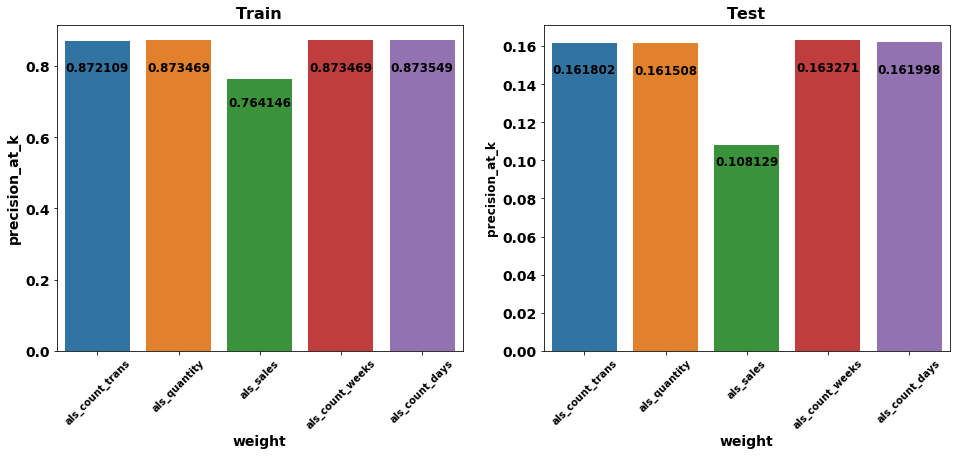

In [86]:
df_chart_train = pd.DataFrame(list(zip(list_variants_weight, list_precision_train)), columns = ['weight', 'precision'])
df_chart_test  = pd.DataFrame(list(zip(list_variants_weight, list_precision_test)),  columns = ['weight', 'precision'])

fig, ax = plt.subplots()
fig.set_size_inches(16, 6)

plt.subplot(121)
g1 = sns.barplot(x = 'weight', y = 'precision', data = df_chart_train) #, color = 'steelblue')

plt.xlabel('weight',         fontsize = 14, weight = 'bold')
plt.ylabel('precision_at_k', fontsize = 14, weight = 'bold')
plt.title('Train',           fontsize = 16, weight = 'bold')

plt.xticks(fontsize = 10, weight = 'bold')
plt.yticks(fontsize = 14, weight = 'bold')
plt.xticks(rotation = 45)

plt.subplot(122)
g2 = sns.barplot(x = 'weight', y = 'precision', data = df_chart_test)

plt.xlabel('weight',         fontsize = 14, weight = 'bold')
plt.ylabel('precision_at_k', fontsize = 12, weight = 'bold')
plt.title('Test',            fontsize = 16, weight = 'bold')

plt.xticks(fontsize = 10, weight = 'bold')
plt.yticks(fontsize = 14, weight = 'bold')
plt.xticks(rotation = 45)

# значения меток данных для Train
for index, row in df_chart_train.iterrows():
    g1.text(row.name, row.precision * 0.9, str(round(row.precision, 6)), 
               color = 'black', ha = "center", weight = 'bold', size = 12)

# значения меток данных для Test
for index, row in df_chart_test.iterrows():
    g2.text(row.name, row.precision * 0.9, str(round(row.precision, 6)),
               color = 'black', ha = "center", weight = 'bold', size = 12)    

plt.show()

### Выводы

**На трейне**

* В целом все варинты, за исключением als_sales (общий оборот), показали достаточно высокое качество, ~0.87.
* Лучшее качество получено для 2-го и 4-го вариантов взвешивания, als_quantity и als_count_weeks - это общее, суммарное количество и уникальное количество периодов (недель).

**На тесте**

* Наблюдается похожая картина, только значения в разы ниже в диапазоне 0,10 - 0,16.
* Четыре алгоритма имеют примерно одинаковые результаты 0,16. 
* Также провалился метод las_sales, только здесь еще сильнее до 0,10.
* А лучший результат у als_count_weeks.

### Задание 2. Оптимизация гиперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.RandomSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

#### Перебор значений параметров (для Train и для Test)

In [114]:
# списки значений factors и regularization

# list_factors = [10, 50, 100, 200]
# list_regularization = [0.1, 0.01, 0.001, 0.0001]

list_factors = [10, 50, 100]
list_regularization = [0.01, 0.001, 0.0001]

# Функция перебора параметров
def get_table_params(data, data_valid):

    # реальные данные user + item
    result = data_valid.groupby('user_id')['item_id'].unique().reset_index()
    result.columns = ['user_id', 'actual']
    result['actual'] = result['actual'].apply(lambda x: list(x))

    #---------------------------------------------------------------------------------------------------------------
    # матрица user_item_matrix; Вес = уникальное количество недель
    user_item_matrix = get_matrix_user_item(data, 3)    
    sparse_user_item = csr_matrix(user_item_matrix).tocsr()

    list_params = []
    
    # Перебор всех значений factors и regularization
    i = 0
    for f in list_factors:
        for r in list_regularization:

            i += 1
            param_key = param_key = str(f) + '_' + str(r)
            
            # замер времени - начало
            start_time = time.monotonic()

            # модель
            model = AlternatingLeastSquares( factors = f,
                                            regularization = r,
                                            iterations = 15, 
                                            calculate_training_loss = True, 
                                            num_threads = 4)
            
            model.fit( csr_matrix(user_item_matrix).T.tocsr(), show_progress = False)
            
            # замер времени - окончание
            end_time = time.monotonic()
            time_fit = timedelta(seconds = end_time - start_time)
            
            # замер времени - начало
            start_time = time.monotonic()                      
            
            # предсказание
            result[param_key] = result['user_id'].apply(
                                                    lambda x: get_recommendations(x, sparse_user_item, model = model, N = 5))
            
            # замер времени - окончание
            end_time = time.monotonic()
            time_recommend = timedelta(seconds = end_time - start_time)
            
            time_total = time_fit + time_recommend
            print(f'{i}\t factors = {f}\t regularization = {r}\t\t time_fit = {time_fit}\t time_recommend = {time_recommend}')

            # список параметров для оценки
            list_params.append( [param_key, f, r, time_fit, time_recommend, time_total, 0.0] )
            
    return result, list_params

In [115]:
# Расчет оценки качества для каждой комбинации параметров
def get_params_evaluation(result, list_params, sort_type):

    list_result = []

    for param in list_params:
        
        param_key = param[0]
        param[6] = result.apply(lambda x: precision_at_k( x[param_key], x['actual'],  5), axis = 1 ).mean()
       
        list_result.append(param)

    if (sort_type == 'time'):   # сортировка по времени выполнения (time_total)
        list_result.sort(key = lambda x: x[5], reverse = True)    
    
    else:                       # сортировка по времени выполнения по качеству (precison_at_k)
        list_result.sort(key = lambda x: x[6], reverse = True)

    print(f'Место  Factor Regularization\t Time_fit\t Time_recommend\t Time_total\t Precision_at_k\t Key')     
    print()
    for place, res in enumerate(list_result):
        print(f'   {place + 1}   {res[1]}\t {res[2]}\t\t {res[3]}\t {res[4]}\t {res[5]}\t {round(res[6], 6)}\t {res[0]} ')
        
    return list_result

#### Заполнение значений параметров (factors и regularization) и их оценка

#### для Train

In [116]:
%%time
result_params_train, list_params_train = get_table_params(data_train, data_train)

1	 factors = 10	 regularization = 0.01		 time_fit = 0:00:04.797000	 time_recommend = 0:00:18.782000
2	 factors = 10	 regularization = 0.001		 time_fit = 0:00:04.546000	 time_recommend = 0:00:22.797000
3	 factors = 10	 regularization = 0.0001		 time_fit = 0:00:04.984000	 time_recommend = 0:00:26.907000
4	 factors = 50	 regularization = 0.01		 time_fit = 0:00:06.281000	 time_recommend = 0:00:51.953000
5	 factors = 50	 regularization = 0.001		 time_fit = 0:00:06.984000	 time_recommend = 0:00:44.328000
6	 factors = 50	 regularization = 0.0001		 time_fit = 0:00:05.938000	 time_recommend = 0:00:48.109000
7	 factors = 100	 regularization = 0.01		 time_fit = 0:00:06.203000	 time_recommend = 0:01:45.204000
8	 factors = 100	 regularization = 0.001		 time_fit = 0:00:05.562000	 time_recommend = 0:01:31.500000
9	 factors = 100	 regularization = 0.0001		 time_fit = 0:00:05.344000	 time_recommend = 0:01:28.234000
Wall time: 9min 25s


#### для Test

In [117]:
%%time
result_params_test, list_params_test = get_table_params(data_train, data_test)

1	 factors = 10	 regularization = 0.01		 time_fit = 0:00:04.359000	 time_recommend = 0:00:16.297000
2	 factors = 10	 regularization = 0.001		 time_fit = 0:00:04.407000	 time_recommend = 0:00:16.281000
3	 factors = 10	 regularization = 0.0001		 time_fit = 0:00:04.265000	 time_recommend = 0:00:15.891000
4	 factors = 50	 regularization = 0.01		 time_fit = 0:00:05.281000	 time_recommend = 0:00:31.047000
5	 factors = 50	 regularization = 0.001		 time_fit = 0:00:04.703000	 time_recommend = 0:00:29.657000
6	 factors = 50	 regularization = 0.0001		 time_fit = 0:00:04.703000	 time_recommend = 0:00:29.140000
7	 factors = 100	 regularization = 0.01		 time_fit = 0:00:05.250000	 time_recommend = 0:01:04.125000
8	 factors = 100	 regularization = 0.001		 time_fit = 0:00:05.312000	 time_recommend = 0:01:03.813000
9	 factors = 100	 regularization = 0.0001		 time_fit = 0:00:05.250000	 time_recommend = 0:01:28.562000
Wall time: 6min 53s


### Результаты сравнения параметров

### для Train

#### Места по Времени обучения time_total

In [118]:
# по времени обучения
res_1 = get_params_evaluation(result_params_train, list_params_train, 'time')

Место  Factor Regularization	 Time_fit	 Time_recommend	 Time_total	 Precision_at_k	 Key

   1   100	 0.01		 0:00:06.203000	 0:01:45.204000	 0:01:51.407000	 0.858904	 100_0.01 
   2   100	 0.001		 0:00:05.562000	 0:01:31.500000	 0:01:37.062000	 0.868027	 100_0.001 
   3   100	 0.0001		 0:00:05.344000	 0:01:28.234000	 0:01:33.578000	 0.868347	 100_0.0001 
   4   50	 0.01		 0:00:06.281000	 0:00:51.953000	 0:00:58.234000	 0.772549	 50_0.01 
   5   50	 0.0001		 0:00:05.938000	 0:00:48.109000	 0:00:54.047000	 0.77407	 50_0.0001 
   6   50	 0.001		 0:00:06.984000	 0:00:44.328000	 0:00:51.312000	 0.77503	 50_0.001 
   7   10	 0.0001		 0:00:04.984000	 0:00:26.907000	 0:00:31.891000	 0.708363	 10_0.0001 
   8   10	 0.001		 0:00:04.546000	 0:00:22.797000	 0:00:27.343000	 0.706363	 10_0.001 
   9   10	 0.01		 0:00:04.797000	 0:00:18.782000	 0:00:23.579000	 0.707003	 10_0.01 


#### Места по Качеству precision_at_k

In [119]:
# по качеству
res_2 = get_params_evaluation(result_params_train, list_params_train, 'precision')

Место  Factor Regularization	 Time_fit	 Time_recommend	 Time_total	 Precision_at_k	 Key

   1   100	 0.0001		 0:00:05.344000	 0:01:28.234000	 0:01:33.578000	 0.868347	 100_0.0001 
   2   100	 0.001		 0:00:05.562000	 0:01:31.500000	 0:01:37.062000	 0.868027	 100_0.001 
   3   100	 0.01		 0:00:06.203000	 0:01:45.204000	 0:01:51.407000	 0.858904	 100_0.01 
   4   50	 0.001		 0:00:06.984000	 0:00:44.328000	 0:00:51.312000	 0.77503	 50_0.001 
   5   50	 0.0001		 0:00:05.938000	 0:00:48.109000	 0:00:54.047000	 0.77407	 50_0.0001 
   6   50	 0.01		 0:00:06.281000	 0:00:51.953000	 0:00:58.234000	 0.772549	 50_0.01 
   7   10	 0.0001		 0:00:04.984000	 0:00:26.907000	 0:00:31.891000	 0.708363	 10_0.0001 
   8   10	 0.01		 0:00:04.797000	 0:00:18.782000	 0:00:23.579000	 0.707003	 10_0.01 
   9   10	 0.001		 0:00:04.546000	 0:00:22.797000	 0:00:27.343000	 0.706363	 10_0.001 


### для Test

#### Места по Времени обучения time_total

In [120]:
# по времени обучения
res_3 = get_params_evaluation(result_params_test, list_params_test, 'time')

Место  Factor Regularization	 Time_fit	 Time_recommend	 Time_total	 Precision_at_k	 Key

   1   100	 0.0001		 0:00:05.250000	 0:01:28.562000	 0:01:33.812000	 0.161019	 100_0.0001 
   2   100	 0.01		 0:00:05.250000	 0:01:04.125000	 0:01:09.375000	 0.164838	 100_0.01 
   3   100	 0.001		 0:00:05.312000	 0:01:03.813000	 0:01:09.125000	 0.163467	 100_0.001 
   4   50	 0.01		 0:00:05.281000	 0:00:31.047000	 0:00:36.328000	 0.166797	 50_0.01 
   5   50	 0.001		 0:00:04.703000	 0:00:29.657000	 0:00:34.360000	 0.164447	 50_0.001 
   6   50	 0.0001		 0:00:04.703000	 0:00:29.140000	 0:00:33.843000	 0.162096	 50_0.0001 
   7   10	 0.001		 0:00:04.407000	 0:00:16.281000	 0:00:20.688000	 0.168854	 10_0.001 
   8   10	 0.01		 0:00:04.359000	 0:00:16.297000	 0:00:20.656000	 0.172576	 10_0.01 
   9   10	 0.0001		 0:00:04.265000	 0:00:15.891000	 0:00:20.156000	 0.170127	 10_0.0001 


#### Места по Качеству precision_at_k

In [121]:
# по качеству
res_4 = get_params_evaluation(result_params_test, list_params_test, 'precision')

Место  Factor Regularization	 Time_fit	 Time_recommend	 Time_total	 Precision_at_k	 Key

   1   10	 0.01		 0:00:04.359000	 0:00:16.297000	 0:00:20.656000	 0.172576	 10_0.01 
   2   10	 0.0001		 0:00:04.265000	 0:00:15.891000	 0:00:20.156000	 0.170127	 10_0.0001 
   3   10	 0.001		 0:00:04.407000	 0:00:16.281000	 0:00:20.688000	 0.168854	 10_0.001 
   4   50	 0.01		 0:00:05.281000	 0:00:31.047000	 0:00:36.328000	 0.166797	 50_0.01 
   5   100	 0.01		 0:00:05.250000	 0:01:04.125000	 0:01:09.375000	 0.164838	 100_0.01 
   6   50	 0.001		 0:00:04.703000	 0:00:29.657000	 0:00:34.360000	 0.164447	 50_0.001 
   7   100	 0.001		 0:00:05.312000	 0:01:03.813000	 0:01:09.125000	 0.163467	 100_0.001 
   8   50	 0.0001		 0:00:04.703000	 0:00:29.140000	 0:00:33.843000	 0.162096	 50_0.0001 
   9   100	 0.0001		 0:00:05.250000	 0:01:28.562000	 0:01:33.812000	 0.161019	 100_0.0001 


### Выводы

### Для Train

#### По времени обучения

1. Полученные результаты показывают, что время **Время обучения** очень чувствительно к параметру **factors**. 
Точнее, само время обучения модели **time_fit** при увеличении **factors** растет, но незначительно.
А вот, время получения рекоммендаций **time_recommend**, при увеличении значения **factors**, прирастает очень прилично.


2. А от параметра **regularization** **Время обучения** не зависит. Результаты измерений получились разнонаправленные, что-то больше, что-то меньше.

#### По качеству

1. **Качество** также зависит от параметра **factors**. С увеличением значения **factors**, **Качество** модели растет.
Точнее, само время обучения модели **time_fit** при увеличении factors растет, но незначительно.
А вот, время получения рекоммендаций **time_recommend**, при увеличении значения factors, прирастает очень прилично.


2. И аналогично **Времени обучения**, получилось, что **Качество** не зависит от **regularization**. Результаты измерений также получились разнонаправленные.

### Для Test

1. Параметр **Время обучения** реагирует аналогичным образом, как и для тренировочного набора, и на **factors** и на **regularization**


2. А по **Качеству** получилась обратная картина, лучшие результаты получены для наименьшего значения **factors** = 10. 
Для **regularization** результаты измерений вновь получились разнонаправленные, четкой зависимости не прослеживается.